<a href="https://colab.research.google.com/github/Ibsen-Gomes/Deep_learning_Colab/blob/main/Deep_learning_breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### PyTorch package import:

In [2]:
import torch
torch.__version__

'2.0.1+cu118'

In [3]:
import torch.nn as nn

### Load data

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
previsores = pd.read_csv('/content/drive/MyDrive/Deep_learning/entradas_breast.csv')
classe = pd.read_csv('/content/drive/MyDrive/Deep_learning/saidas_breast.csv')



In [6]:
previsores.shape

(569, 30)

In [7]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [8]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [9]:
np.unique(classe)

array([0, 1])

### Sample count for each label:

<Axes: xlabel='0', ylabel='count'>

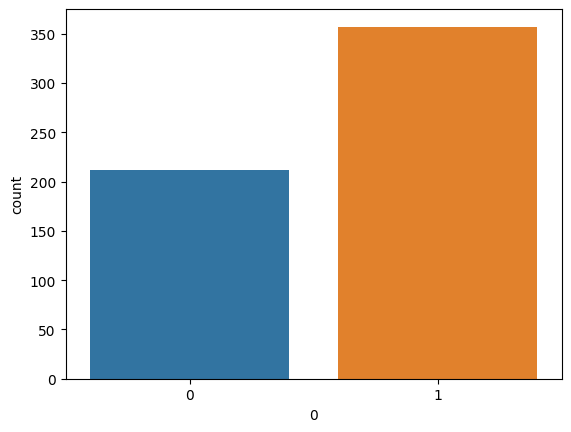

In [10]:
sns.countplot(x=classe['0'])

### Split data into training and testing:

In [11]:
previsores_train, previsores_test, classe_train, classe_test = train_test_split(previsores,
                                                                               classe,
                                                                               test_size = 0.25)

In [12]:
print(previsores_train.shape, classe_train.shape, previsores_test.shape, classe_test.shape) # check the shapes

(426, 30) (426, 1) (143, 30) (143, 1)


### Transformation into Tensors:

##### Essential for processing on GPUs

In [13]:
type(previsores_train)

pandas.core.frame.DataFrame

In [14]:
type(np.array(previsores_train))

numpy.ndarray

In [15]:
previsores_train = torch.tensor(np.array(previsores_train), dtype = torch.float)
classe_train = torch.tensor(np.array(classe_train), dtype = torch.float)

In [16]:
type(previsores_train)

torch.Tensor

In [17]:
type(classe_train)

torch.Tensor

#### Creation of a dataset with the union of predictors and classes:

In [18]:
dataset = torch.utils.data.TensorDataset(previsores_train, classe_train)

In [19]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [20]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

### Model building:

In [21]:
# 30 neurônios no input = 30 atributos previsores
# 16 neurônios 1° camada oculta
# 16 neurônios 2° camada oculta
# pq 16 neurônios nas redes ocultas? -> (entradas + saídas) / 2 = (30+1)/2 = 16
# 1 neurônio na camada de saída (probabilidade de uma classe 0 ou 1)

classificador = nn.Sequential( # sequencia de camada

    nn.Linear(in_features=30, out_features=16,), # Linear = todas as camadas de entrada ligado a todos de saída
    nn.ReLU(), # função de ativação aplicado no 1° camdada de 16 neurônios

    nn.Linear(16, 16), # Linear = todas as 16 camadas ligadas aos próximos 16 neurônios
    nn.ReLU(), # função de ativação aplicado no 2° camada de 16 neurônios

    nn.Linear(16, 1), # Linear = todas as 16 camadas ligadas ao neurônio de saída
    nn.Sigmoid(), # função de ativação na camada com 1 neurônio
)


In [22]:
# observar a estrutura da rede neural:

classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [23]:
# Função de erro:

criterion = nn.BCELoss()
# Binary cross entropy (comparação entre previsão e gabarito)

In [24]:
# Otimizador

optimizer = torch.optim.Adam(classificador.parameters(),
                             lr = 0.001, # taxa de aprendizado
                             weight_decay = 0.0001) # decaimento dos pesos
                             # diminui lr com o passar das epocas

In [25]:
# Necessário um For para treinamento (diferente do TensorFLow ou Sklearn que tem um fit)
for epoch in range(200): # Em 1 epoca passando por 426 registros de 10 em 10 (batch) registros
  running_loss = 0. # Inicializar o acumulador do erro

  for data in train_loader: # train_loader = dados dividido em 10 em 10 registros

    inputs, labels = data # inputs=previsores e labels=classes
    optimizer.zero_grad() # zerar, pq em cada ajuste de peso é necessario calcular o gradiente separadamente

    outputs = classificador(inputs) #passando os inputs no modelo e gerando os outputs -> processo forward na rede (esqeurda p/ direita)
    # outputs-> classificador.forward(inputs)
    loss = criterion(outputs, labels) #calculo do erro entre labels reais e preditos
    loss.backward() #voltando e atualizando os pesos processo de backward na rede (direita p/ esquerda)
    optimizer.step() #atualização dos pesos usando o "Adam"

    running_loss += loss.item() #somatorio do erro
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))


Época   1: perda 10.76845
Época   2: perda 2.76033
Época   3: perda 1.41596
Época   4: perda 0.70450
Época   5: perda 0.68355
Época   6: perda 0.38389
Época   7: perda 0.60377
Época   8: perda 0.28244
Época   9: perda 0.25952
Época  10: perda 0.24751
Época  11: perda 0.31085
Época  12: perda 0.23567
Época  13: perda 0.25210
Época  14: perda 0.23270
Época  15: perda 0.23848
Época  16: perda 0.20633
Época  17: perda 0.24387
Época  18: perda 0.28400
Época  19: perda 0.22199
Época  20: perda 0.22885
Época  21: perda 0.19840
Época  22: perda 0.26132
Época  23: perda 0.27163
Época  24: perda 0.22426
Época  25: perda 0.26579
Época  26: perda 0.22590
Época  27: perda 0.20857
Época  28: perda 0.20451
Época  29: perda 0.20278
Época  30: perda 0.20289
Época  31: perda 0.23885
Época  32: perda 0.19190
Época  33: perda 0.24389
Época  34: perda 0.38608
Época  35: perda 0.23924
Época  36: perda 0.26869
Época  37: perda 0.22983
Época  38: perda 0.35327
Época  39: perda 0.41073
Época  40: perda 0.23598

### Visualization of weights:

In [26]:
params = list(classificador.parameters())


In [27]:
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [28]:
# ligação (pesos) entre todas os 30 inputs da camadas de entrada com os 16 neurônios da primeira camada oculta
print(pesos0)

Parameter containing:
tensor([[-1.9109e-01,  1.7119e-01, -3.5133e-01,  6.7053e-02, -8.2535e-02,
          1.4880e-01, -1.0899e-01, -6.4639e-03,  3.3289e-02,  1.5473e-01,
          1.7561e-01,  2.3933e-02,  5.5499e-02,  1.5561e-01,  1.0422e-02,
         -3.9185e-02,  1.0401e-01, -1.9042e-02,  3.9523e-01,  1.0048e-01,
         -4.3885e-01,  1.7833e-01, -3.0826e-01,  5.3839e-02, -3.4434e-01,
         -1.5011e-01, -4.0621e-01, -2.5918e-01, -1.7752e-01,  8.8531e-02],
        [ 6.0245e-02, -1.0450e-01, -1.3004e-01, -2.3399e-03,  1.2431e-01,
          5.5083e-02,  1.0114e-01,  1.3782e-01, -6.1712e-02, -5.6312e-02,
          1.1227e-01, -3.9852e-02,  4.2403e-02,  1.2821e-01,  2.0907e-02,
         -1.5227e-02,  1.7265e-01, -1.2454e-01,  2.7212e-01,  1.6477e-01,
         -4.9475e-01,  1.6507e-01, -3.2307e-01,  1.6869e-01,  1.1211e-01,
          8.4064e-02,  4.9427e-02,  6.9157e-02,  1.5138e-01,  2.6271e-01],
        [ 5.3393e-02, -3.6048e-01,  1.9123e-01, -6.2063e-02, -2.3654e-01,
          2.94

In [29]:
# Unidade de bias na 1° camada oculta
bias0 = params[1]
bias0.shape

torch.Size([16])

In [30]:
# ligação (pesos) entre todas os 16 neurônios da primeira camada oculta com os 16 neurônios da segunda camada oculta.
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [31]:
# Unidade de bias na 2° camada oculta
bias1 = params[3]
bias1.shape

torch.Size([16])

### Model evaluation:

In [32]:
classificador.eval() # .eval = significa que o classificador em modo avaliação


Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [33]:
type(previsores_test)

pandas.core.frame.DataFrame

In [34]:
previsores_test = torch.tensor(np.array(previsores_test), dtype=torch.float)

In [35]:
type(previsores_test)

torch.Tensor

In [36]:
previsoes = classificador.forward(previsores_test) # passar pela rede neural em forward

In [37]:
# probabilidade entre 0 e 1
previsoes

tensor([[4.5830e-01],
        [1.1794e-07],
        [2.1472e-04],
        [9.9999e-01],
        [9.9995e-01],
        [2.1025e-09],
        [5.3036e-09],
        [5.6333e-01],
        [9.9973e-01],
        [9.9247e-01],
        [9.9428e-01],
        [3.7188e-03],
        [9.9941e-01],
        [3.2833e-01],
        [1.0000e+00],
        [9.5526e-01],
        [9.9908e-01],
        [9.9870e-01],
        [1.0000e+00],
        [2.2425e-07],
        [3.5586e-04],
        [9.6723e-01],
        [9.0230e-13],
        [9.9974e-01],
        [9.9261e-01],
        [9.9957e-01],
        [9.9910e-01],
        [9.9999e-01],
        [9.8977e-01],
        [1.5022e-06],
        [9.9992e-01],
        [9.9919e-01],
        [1.0000e+00],
        [4.5617e-01],
        [9.9948e-01],
        [9.9989e-01],
        [7.6538e-04],
        [9.8525e-01],
        [3.1276e-08],
        [5.8282e-01],
        [9.6287e-01],
        [9.1047e-03],
        [9.9858e-01],
        [8.3760e-01],
        [9.9999e-01],
        [9

In [38]:
# Limiar de classificação

previsoes = np.array(previsoes> 0.5) # valor 0.5 de acordo com o cenário
previsoes

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [

In [39]:
previsoes.shape

(143, 1)

In [40]:
classe_test

,0
204,1
70,0
131,0
431,1
540,1
...,...
89,1
199,0
411,1
18,0


In [41]:
# Taxa de acerto, comparação entre as etiquetas 0 e 1 com as str True e False:

taxa_acerto = accuracy_score(classe_test, previsoes)
taxa_acerto

0.9230769230769231

In [42]:
# Matrix de confusão:

matrix = confusion_matrix(classe_test, previsoes)
matrix

array([[47,  7],
       [ 4, 85]])

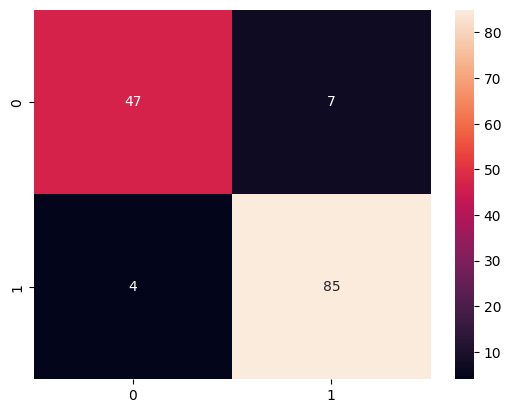

In [43]:
sns.heatmap(matrix, annot=True);

# Part 2

## Utilização da validação cruzada e dropout

### Cross Validation

In [44]:
!pip install skorch

In [45]:
from skorch import NeuralNetBinaryClassifier
import torch
from sklearn.model_selection import cross_val_score
torch.__version__

'2.0.1+cu118'

### Data...

In [46]:
np.random.seed(42)
torch.manual_seed(42)

In [47]:
previsores = pd.read_csv('/content/drive/MyDrive/Deep_learning/entradas_breast.csv')
classe = pd.read_csv('/content/drive/MyDrive/Deep_learning/saidas_breast.csv')



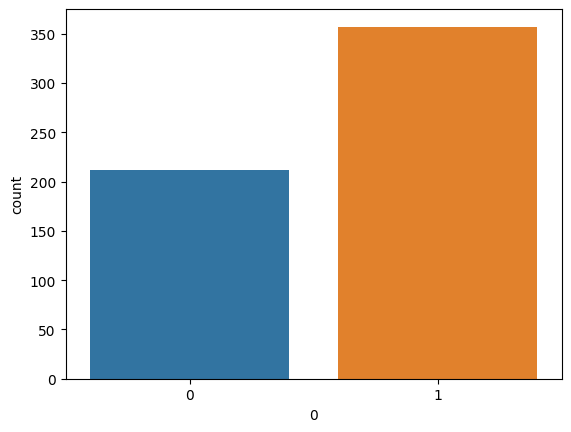

In [48]:
sns.countplot(x=classe['0']);

In [49]:
classe.shape

(569, 1)

In [50]:
previsores = np.array(previsores, dtype='float32')
classe = np.array(classe, dtype='float32').squeeze(1)

In [51]:
# retirada do 1 no shape original para utilização do PyTorch
classe.shape

(569,)

In [52]:
#type(classe)
type(previsores)

numpy.ndarray

### Classe para estrutura da rede neural:

In [53]:
# O skorch exige que a rn seja passada como uma classe que herda do nn.Module:

class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # Contruindo a rede: 30 -> 16 -> 16 -> 1

    # 1) 30 -> 16:
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    # 2) 16 -> 16:
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    # 3) 16 -> 1:
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO (ver detalhes no texto acima) **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO (ver detalhes no texto acima) **
    return X

### Utilizando o Skorch:

In [54]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss,
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False) #False para que o split seja feita a validação cruzada

### Cross Validation:

In [55]:
resultados = cross_val_score(classificador_sklearn,previsores,classe,cv=10,scoring='accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    91294.3561  0.1484
      2    72722.7842  0.1683
      3    57326.1895  0.1267
      4    45113.9061  0.1388
      5    35504.2660  0.1984
      6    27942.9745  0.2327
      7    21966.1433  0.2596
      8    17219.1712  0.0847
      9    13405.5771  0.0720
     10    10299.5128  0.0731
     11     7712.1263  0.0737
     12     5558.0446  0.0769
     13     3777.9468  0.0804
     14     2149.4901  0.0778
     15      642.8538  0.0908
     16      118.2383  0.0821
     17      107.0518  0.0731
     18       96.8006  0.0724
     19       87.7538  0.0837
     20       77.5083  0.0733
     21       69.4041  0.1094
     22       64.9020  0.1152
     23       58.1061  0.1080
     24       51.6602  0.0828
     25       47.0568  0.0694
     26       38.7777  0.0726
     27       36.0821  0.0865
     28       32.8395  0.0852
     29       29.8898  0.0752
     30       28.6489  0.0742
     31       27.5908  0.0739
     32   

In [56]:
resultados.shape

(10,)

In [57]:
# Acurácia de cada uma das 10 partições da validação cruzada:
resultados

array([0.80701754, 0.78947368, 0.84210526, 0.9122807 , 0.8245614 ,
       0.94736842, 0.84210526, 0.87719298, 0.50877193, 0.875     ])

In [58]:
media = resultados.mean()
media

0.8225877192982456

In [59]:
desvio = resultados.std()
desvio

0.11398636779767021

### Dropout

##### Evita Overffiting

In [65]:
# O skorch exige que a rn seja passada como uma classe que herda do nn.Module:

class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # Contruindo a rede: 30 -> 16 -> 16 -> 1

    # 1) 30 -> 16:
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout0 = nn.Dropout(0.1)
    # 2) 16 -> 16:
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.1)
    # 3) 16 -> 1:
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)
    # self.output = nn.Sigmoid() ** ATUALIZAÇÃO (ver detalhes no texto acima) **

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout1(X)
    X = self.dense2(X)
    # X = self.output(X) ** ATUALIZAÇÃO (ver detalhes no texto acima) **
    return X

In [66]:
classificador_sklearn = NeuralNetBinaryClassifier(module=classificador_torch,
                                                  criterion=torch.nn.BCEWithLogitsLoss,
                                                  optimizer=torch.optim.Adam,
                                                  lr=0.001,
                                                  optimizer__weight_decay=0.0001,
                                                  max_epochs=100,
                                                  batch_size=10,
                                                  train_split=False) #False para que o split seja feita a validação cruzada

In [67]:
resultados = cross_val_score(classificador_sklearn,previsores,classe,cv=10,scoring='accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    91270.4574  0.1806
      2    74912.4777  0.1576
      3    58526.1108  0.1586
      4    46221.4592  0.1816
      5    36319.4100  0.1700
      6    28615.7540  0.0780
      7    21928.5014  0.1343
      8    17328.7621  0.1253
      9    12672.3605  0.2933
     10     8656.2915  0.2420
     11     5516.5527  0.1557
     12     2778.3078  0.1220
     13     1341.5398  0.1477
     14     1186.4450  0.2121
     15      882.7500  0.1900
     16     1017.4347  0.2880
     17      918.5328  0.4917
     18      907.6660  0.5359
     19      958.9967  0.3677
     20      856.3429  0.3587
     21      952.7959  0.4848
     22      828.2438  0.4618
     23      812.4978  0.3420
     24      798.8186  0.4683
     25      619.5692  0.4178
     26      598.8920  0.5115
     27      635.8735  0.2290
     28      619.8163  0.2104
     29      645.8997  0.1710
     30      556.4352  0.3655
     31      591.3395  0.3408
     32   

In [68]:
media = resultados.mean()
desvio = resultados.std()
media, desvio

(0.7997807017543859, 0.05905641086717138)

In [69]:
resultados

array([0.77192982, 0.85964912, 0.80701754, 0.68421053, 0.78947368,
       0.73684211, 0.8245614 , 0.87719298, 0.77192982, 0.875     ])